# Filtrage

In [1]:
from random import expovariate
import matplotlib.pyplot as plt
a = 5
b = 10
mu = 0.2
T = 10

Nous avons l'expression de $h$ qui est donnée par $h(s)=\frac{f(s)}{1-F(s)}$. Etant donnée que $\tau$ suit une loi exponentielle de paramètre $\mu$, nous connaissons sa densité ainsi que sa fonction de répartition. Nous avons donc :  $h(s)=\mathbb{1}_{s \geq 0} \frac{\mu e^{-\mu s}}{1-(1-e^{-\mu s})} = \mathbb{1}_{s \geq 0} \mu$.

Nous allons maintenant simuler une trajectoire de N sur un intervalle de temps [0,10] à l'aide du premier algorithme du cours :

In [2]:
def lambd(t, tau):
    if t < tau:
        return a
    else:
        return b

Traçage de la trajectoire : 

1.5485189379934678


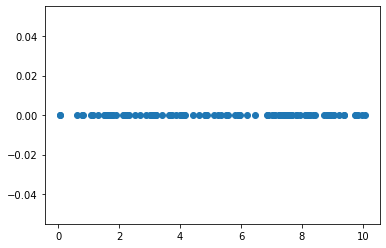

In [3]:
def trajectoire(l, T):
    t = 0
    traj = []
    tau = expovariate(mu)
    while t <= T:
        x = expovariate(l(t, tau))
        t += x
        traj.append(t)
    return traj, tau

traj, tau = trajectoire(lambd, T)
plt.scatter(traj, [0]*len(traj))
print(tau)

## Approximation avec $\hat{Z}$

Nous allons maintenant représenter $\hat{Z}(s)$ pour cette trajectoire. $\hat{Z}$ est solution d'une équation stocastique entre chaque saut que nous allons "résoudre" par une méthode d'Euler entre chaque saut, et nous avons également une équation pour $\hat{Z}$ au moment des sauts :

1.7031780461544443


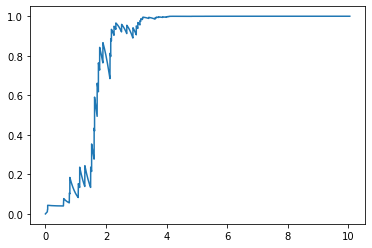

In [4]:
def Z_chap_intervalle(n, t0, tn, init):
    h = (tn-t0)/n
    tps = [t0 + k*h for k in range(n-1)]
    Z0 = init
    res = [Z0]
    for k in range(1, n-1):
        res.append(res[-1]+(mu-(b-a)*res[-1])*(1-res[-1])*h)
    return res, tps

def Z_chap(traj):
    traj = [0] + traj.copy()
    temps = [0]
    Z0 = 0
    res = [Z0]
    for i in range(len(traj)-1):
        tmp = Z_chap_intervalle(100, traj[i], traj[i+1], res[-1])
        temps += tmp[1][1:]+[traj[i+1]]
        res += tmp[0][1:]
        res.append(res[-1]+((b-a)*res[-1]*(1-res[-1]))/(a+(b-a)*res[-1]))
    return res, temps

res, temps = Z_chap(traj)
plt.plot(temps, res)
minimum = abs(0.5-res[0])
index = 0
for i in range(len(res)):
    if (abs(0.5-res[i])) < minimum:
        index = i
        minimum = (abs(0.5-res[i]))
print("Approximation de tau : ", temps[index])


Pour approximer $\tau$, nous avons retenu le temps pour lequel $\hat{Z}$ est le plus proche de 0,5.

## Approximation avec k-means

Nous repartons de la trajectoire obtenue. Nous allons créer deux clusters de points, dans l'idée que les deux clusters correspondent à chaque régime. Les clusters sont réalisés avec les points.

5.356955388996458


Text(0.5, 1.0, 'Points by cluster')

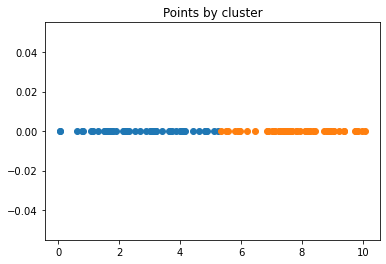

In [5]:
from sklearn.cluster import KMeans
import numpy as np

data = np.vstack((traj,[0]*len(traj))).T

kmeans = KMeans(n_clusters=2, init='k-means++').fit(data)
pred = kmeans.predict(data)
c1 = []
t1 = []
c2 = []
t2 = []
for i in range(len(pred)):
    if pred[i] ==0:
        c1.append(0)
        t1.append(traj[i])
    else:
        c2.append(0)
        t2.append(traj[i])
plt.scatter(t1,c1)
plt.scatter(t2,c2)
print(max(t1[0],t2[0]))
plt.title("Points by cluster")

$\tau$ est alors donné par le temps où on passe au second cluster.

## Comparaison des méthodes

Tout d'abord, au premier regard, la méthode avec $\hat{Z}$ semble meilleure, notamment pour des valeurs de $\tau$ petites. 

En ce qui concerne la précision des méthodes, nous avons calculé l'erreur moyenne de chaque méthode sur 50 exécutions.

In [6]:
def precision(n):
    precision_Z = 0
    precision_kmeans = 0
    n = 100
    for i in range(n):
        traj, tau = trajectoire(lambd, T)
        res, temps = Z_chap(traj)
        minimum = abs(0.5-res[0])
        index = 0
        data = np.vstack((traj,[0]*len(traj))).T
        kmeans = KMeans(n_clusters=2, init='k-means++').fit(data)
        pred = kmeans.predict(data)
        t1 = []
        t2 = []
        for i in range(len(res)):
            if (abs(0.5-res[i])) < minimum:
                index = i
                minimum = (abs(0.5-res[i]))
        for i in range(len(pred)):
            if pred[i] ==0:
                t1.append(traj[i])
            else:
                t2.append(traj[i])
        precision_Z += abs(temps[index]-tau)
        precision_kmeans += abs(max(t1[0],t2[0])-tau)
    precision_Z /= n
    precision_kmeans /= n
    return precision_Z, precision_kmeans

n = 50
precisions = precision(n)
print("Erreur moyenne réalisée sur %s tests pour Z chapeau : %s" % (n, precisions[0]))
print("Erreur moyenne réalisée sur %s tests pour Z chapeau : %s" % (n, precisions[1]))

Erreur moyenne réalisée sur 50 tests pour Z chapeau : 2.748234431593762
Erreur moyenne réalisée sur 50 tests pour Z chapeau : 4.393163559443659


Nous pouvons donc constater que la méthode avec $\hat{Z}$ est bien meilleure que celle avec k-means.

Cherchons maintenant à comparer la robustesse des méthodes. Tout d'abord, faisons varier $a$ de 1 à 9, toutes choses étant égales par ailleurs aux paramètres de départ, et voyons le comportement des méthodes (nous recalculons l'erreur moyenne sur 50 exécutions) :

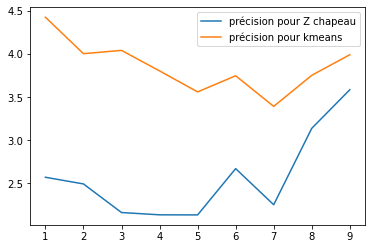

In [7]:
p1 = []
p2 = []
for a in range(1,10):
    prec = precision(50)
    p1.append(prec[0])
    p2.append(prec[1])
plt.plot(range(1,10), p1)
plt.plot(range(1,10), p2)
plt.legend(["précision pour Z chapeau", "précision pour kmeans"])

Nous pouvons donc constater que les méthodes sont assez robustes sauf quand $a$ et $b$ sont proches pour $\hat{Z}$.

Réalisons la même expérience avec $b$ qui varie entre 10 et 300 par dizaine, toutes choses étant égales par ailleurs :

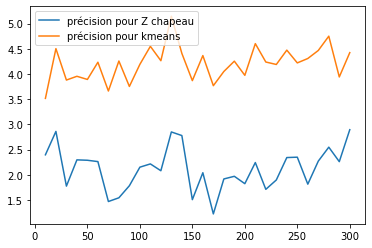

In [8]:
a = 5
p1 = []
p2 = []
for b in [10*k for k in range(1,31)]:
    prec = precision(50)
    p1.append(prec[0])
    p2.append(prec[1])
plt.plot([10*k for k in range(1,31)], p1)
plt.plot([10*k for k in range(1,31)], p2)
plt.legend(["précision pour Z chapeau", "précision pour kmeans"])

Nous pouvons voir que de grandes variations ou écarts entre $a$ et $b$ n'influent pas trop sur la variation de l'erreur moyenne.

Menons le même test avec $T$, variant entre 10 et 100 par dizaine :

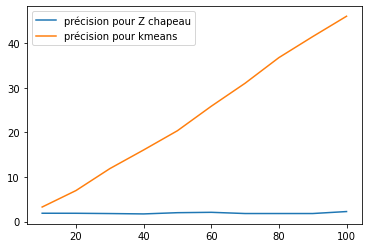

In [9]:
b = 10
p1 = []
p2 = []
for T in [10*k for k in range(1,11)]:
    prec = precision(50)
    p1.append(prec[0])
    p2.append(prec[1])
plt.plot([10*k for k in range(1,11)], p1)
plt.plot([10*k for k in range(1,11)], p2)
plt.legend(["précision pour Z chapeau", "précision pour kmeans"])

Nous pouvons voir que la méthode avec $\hat{Z}$ est plus robuste (l'erreur reste du même ordre de grandeur) tandis que la méthode avec k-means n'est pas robuste pour des variations de $T$ (son erreur moyenne augmente avec T).

Enfin, regardons ce qu'il se passe pour une modification du modèle d'arrivée, pour $\mu$ prenant des valeurs dans {0.001,0.01,0.1,1,10}.

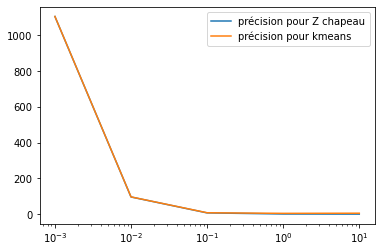

In [10]:
T = 10
p1 = []
p2 = []
for mu in [0.001,0.01,0.1,1,10]:
    prec = precision(50)
    p1.append(prec[0])
    p2.append(prec[1])
plt.xscale('log')
plt.plot([0.001,0.01,0.1,1,10], p1)
plt.plot([0.001,0.01,0.1,1,10], p2)
plt.legend(["précision pour Z chapeau", "précision pour kmeans"])

Ainsi, il apparaît que les deux méthodes répondent mal pour des faibles valeurs de $\mu$.

## Conclusion 

La méthode avec $\hat{Z}$ semble plus adaptée pour le filtrage et détecter les changements de régime. De plus, elle est relativement robuste (à partir du moment où le modèle d'arrivée n'est pas de paramètre trop petit).